## Load all required packages

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np 
from sklearn import mixture
import gensim
from cleantext import clean
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import nltk.tokenize 
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics.pairwise import cosine_similarity
# from dlutils import dlutils
import inspect
import string
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import inspect


## Load data

In [2]:

# input_dir_raw = 'data/heise'
# input_file = os.path.join(os.path.abspath(input_dir_raw), 'heise.txt')
# print(input_file)
# with open(input_file, 'r', encoding='utf-8') as file:
#     input_ = file.readlines()
    
df = pd.read_csv('data/sample_5000.csv', nrows=1500)

### TODO:
    
- integrate cluster center computation into fit method - **done**
- add attributes to pvtm class
    - self.document_vectors - contains the transformed document vectors - np.array - **done**
    - self.document_topics - contains the topic distribution per document - np.array **done**
    - self.n_iter_d2v - number of iterations for the doc2vec algorithm **deprecated**
- add methods to pvtm class
    - transform(string) - transform a given string to vector using a pretrained model **done**
    - get_topics(string) - predict topic distribution for a given string (i.e. document) **done**
- replace dlutils functions with pvtm methods (i.e. add the relevant functions from dlutils into pvtm) **done**


----------------------------------------

-- ccheck https://www.youtube.com/watch?v=77qj9o9pmek
- modulize code (i.e. from .ipynb to .py)
- generate nice repo structure
- create setup.py file and requirements.txt
- generate example in example folder
- Add documentation
    - pvtm.readthedocs.io
- Push to PyPi

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np 
from sklearn import mixture
import gensim
from cleantext import clean
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics.pairwise import cosine_similarity
# from dlutils import dlutils
import inspect
import string
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import inspect


# from gensim.models.doc2vec import TaggedDocument, Doc2Vec
class Documents(object):
    """
    """
    
    def __init__(self, documents):
        self.documents = documents
        self.len = len(documents)

    def __iter__(self):
        for i, doc in enumerate(self.documents):
            yield gensim.models.doc2vec.TaggedDocument(words=doc, tags=[i])




class PVTM(Documents):
    
    def __init__(self, texts, preprocess=True, **kwargs):        
        if preprocess==True:
            texts = self.preprocess(texts, **kwargs)
        x = [kk.split() for kk in texts]
        self.documents = texts
        self.x_docs = Documents(x)
        
    def get_allowed_vocab(self,data, min_df=0.05, max_df=0.95):
        """
        Takes a list of strings.
        Result is a vocabulary based on the corpora from the input dataset.
        Pre-filtering is done using sklearns tfidfVectorizer with settings for min_df and max_df.
        """
        print(min_df, max_df)
        vec = TfidfVectorizer(min_df=min_df, max_df=max_df)

        # fit on dataset
        vec.fit(data)
        # get vocabulary
        vocabulary = set(vec.vocabulary_.keys())
        print(len(vocabulary), 'words in the vocabulary')
        return vocabulary
    
    def popularity_based_prefiltering(self,data, min_df=0.05, max_df=0.95, stopwords=None):
        """popularity based pre-filtering. Ignore rare and common words. 
        Takes a list of strings as input. stopwords is a list of words if provided."""
        vocabulary = self.get_allowed_vocab(data, min_df=min_df, max_df=max_df)
        vocabulary = frozenset(vocabulary)
        if stopwords:
            stopwords = frozenset(stopwords)
        pp = []
        for i, line in enumerate(data):
            rare_removed = list(filter(lambda word: word.lower() in vocabulary, line.split()))
            if stopwords:
                stops_removed = list(filter(lambda word: word.lower() not in stopwords, rare_removed))
                pp.append(" ".join(stops_removed))
            else:
                pp.append(" ".join(rare_removed))
        return pp, vocabulary

    def preprocess(self, texts, **kwargs):        
        '''
        The finction takes a list of texts and removes stopwords as well as very frequent and very unfrequent words.
        The function also uses clean() function from clean-text to lowercase, 
        to remove special characters, number, currency symbols etc. 
        '''
        translator=str.maketrans('','', string.punctuation) # check was der genau macht
        texts = [text.translate(translator) for text in texts]
        
        texts = [clean(x, **{key: value for key, value in kwargs.items() 
                                              if key in inspect.getfullargspec(clean).args}) for x in texts]
        
        cleaned_text, self.vocab = self.popularity_based_prefiltering(texts,**{key: value for key, value in kwargs.items() 
                                              if key in inspect.getfullargspec(self.popularity_based_prefiltering).args}) 
        return cleaned_text
        
    
        
    def fit(self, n_range=10, alpha_value_steps = 0.002, **kwargs):
        """
        """
        self.model = gensim.models.Doc2Vec(**{key: value for key, value in kwargs.items() 
                                              if key in inspect.getfullargspec(gensim.models.Doc2Vec).args})
        # generate doc2vec model vocab
        print('Building vocab')
        self.model.build_vocab(self.x_docs)
        self.model.n_range = n_range
        doc_counts = len(self.documents)
        for epoch in range(n_range):
            print("epoch " + str(epoch))
            self.model.train(self.x_docs, total_examples=doc_counts, epochs=1)
            #     model.save(MODEL_SAVE_NAME)
            self.model.alpha -= alpha_value_steps
            
            
        self.gmm= mixture.GaussianMixture(**{key: value for key, value in kwargs.items() 
                                             if key in inspect.getfullargspec(mixture.GaussianMixture).args})
        
        
        print('GMM Clustering')

        self.doc_vectors=np.array(self.model.docvecs.vectors_docs)

        self.gmm.fit(self.doc_vectors)
        self.BIC = self.gmm.bic(self.doc_vectors)
        print('BIC: {}'.format(self.BIC))
        print('Cluster Center Computation')
        self.cluster_center(np.array(self.model.docvecs.vectors_docs), self.gmm)
        self.document_vectors = np.array(self.model.docvecs.vectors_docs)
        self.document_topics = np.array(self.gmm.predict_proba(self.document_vectors))
        
        
    def cluster_center(self, vectors, gmm):
        """
        Approximates cluster centers for a given clustering from a GMM.
        First method only takes the topic with the highest probability per document into account.
        Averaging the document vectors per topic cluster provides the cluster center for the topic.
        Second method  approximates cluster centers for a given clustering 
        from a GMM with weighted single vectors from a certain topic.
        Returns two lists of the cluster centers.
        """
        self.clustercenter = []
        assignments = gmm.predict(vectors)
        n_components = np.unique(assignments).shape[0]
        for i in range(n_components):
            gmm_centerindexe = np.where(assignments==i, True, False)        
            self.clustercenter.append(vectors[gmm_centerindexe].mean(0))
        
        self.clustercenter_probas = []
        print('vectors', vectors.shape)
        assignments_proba = gmm.predict_proba(vectors)
        n_components = assignments_proba.shape[1] 
        for i in range(n_components):
            center = []
            for j in range(len(vectors)):
                center_j = vectors[j]*assignments_proba[j,i]
                center.append(center_j)
            self.clustercenter_probas.append(np.mean(center,axis=0))
            
    def get_string_vector(self, strings, steps = 0 ):
        '''
        The function takes a string (document) and
        transforms it to vector using a trained model.
        '''
        #string = word_tokenize(string.lower())
        return [self.model.infer_vector(word_tokenize(string.lower()), steps=self.model.n_range+steps) 
                for string in strings]
        
    def get_topic_weights(self, vector):
        '''
        The function takes a document vector 
        and returns a distribution of a given document over all topics.
        '''

        return self.gmm.predict_proba(vector)
        
    def create_wordcloud(self,topic,n_words=100, use_probas=True): 
        """
        The function takes a number of a topic and represents 
        most common word (default=100) in a wordcloud.
        """
        if use_probas==True:
            center_probas = self.clustercenter_probas
        else:
            center_probas= self.clustercenter
        sims = cosine_similarity([center_probas[topic]], self.model.wv.vectors)
        sims = np.argsort(sims)[0][::-1]
        text = [self.model.wv.index2word[k] for k in sims[:n_words]]
        text = ', '.join(text)
        wordcloud = WordCloud(max_font_size=50, max_words=n_words, background_color="white").generate(text)
        plt.figure(figsize=(8, 6))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
    def get_top_words(self,topic, n_words=100, use_probas=True):
        """
        The function takes a number of a topic and returns 
        most common words (default=100) in a list.
        """
        if use_probas==True:
            center_probas = self.clustercenter_probas
        else:
            center_probas= self.clustercenter
        sims = cosine_similarity([center_probas[topic]], self.model.wv.vectors)
        sims = np.argsort(sims)[0][::-1]
        words = [self.model.wv.index2word[k] for k in sims[:n_words]]
        return words
        
        
        

https://stackoverflow.com/questions/23430248/separating-kwargs-for-different-functions

## Create PVTM object

In [4]:
example_len = 150
stop_words = set(nltk.corpus.stopwords.words('english') + ['reuter', '\x03'])

input_=df.text.values
pvtm = PVTM(input_[:example_len], preprocess=True, min_df = 0.05, max_df = 0.5)


0.05 0.5
1140 words in the vocabulary


In [5]:
n_topics=10

pvtm.fit(vector_size=100,dbow_words=1,dm=0,epochs=1,window=5,seed=123,min_count=5,workers=6,alpha=0.025, min_alpha=0.025,
        n_components= n_topics, covariance_type='full', verbose=1, n_init=1, max_iter=200)

Building vocab
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
GMM Clustering
Initialization 0
Initialization converged: True
BIC: 132462.54665270957
Cluster Center Computation
vectors (150, 100)


In [6]:
pvtm.document_topics.shape # number of rows = number of documents; number of columns = number of topics  

(150, 10)

In [7]:
# [pvtm.create_wordcloud(i) for i in range(10)]

## Example text, comparison of GMM and LDA results

In [8]:
# function get_top_words extract most common words of a given topics, default: 100 words
pvtm.get_top_words(5)[:5]

['drive', 'failure', 'hard', '12', 'models']

In [9]:
# Create example document containing top 10 words of each cluster
example_doc = [pvtm.get_top_words(x)[:10] for x in range(pvtm.model.n_range)]

In [10]:
example_doc = [item for sublist in example_doc for item in sublist]
example_doc= ' '.join(example_doc)

In [13]:
new_vector= pvtm.get_string_vector([example_doc], steps=5)

In [68]:
# predict_proba
# Parameters: X : array-like, shape = [n_samples, n_features]

In [15]:
pvtm.get_topic_weights(new_vector[0].reshape(1,-1))

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

## LDA

In [22]:

list_of_list_of_tokens =[word_tokenize(text.lower()) for text in input_[:example_len]]

In [25]:
list_of_list_of_tokens[0]

['ebay',
 'launches',
 'visual',
 'search',
 'tools',
 'that',
 'let',
 'you',
 'shop',
 'using',
 'photos',
 'from',
 'your',
 'phone',
 'or',
 'web0ebay',
 'today',
 'is',
 'launching',
 'two',
 'new',
 'visual',
 'search',
 'tools',
 'that',
 'will',
 'allow',
 'online',
 'shoppers',
 'to',
 'use',
 'photos',
 'they',
 'snap',
 ',',
 'have',
 'saved',
 'on',
 'their',
 'phone',
 ',',
 'or',
 'even',
 'those',
 'they',
 'find',
 'while',
 'browsing',
 'the',
 'web',
 'or',
 'other',
 'social',
 'networking',
 'sites',
 ',',
 'in',
 'order',
 'to',
 'find',
 'matching',
 'products',
 'from',
 'ebay',
 '’',
 's',
 'catalog',
 '.',
 'the',
 'tools',
 ',',
 'image',
 'search',
 'and',
 'find',
 'it',
 'on',
 'ebay',
 ',',
 'leverage',
 'advancements',
 'in',
 'computer',
 'vision',
 'and',
 'deep',
 'learning',
 ',',
 'including',
 'the',
 'use',
 'of',
 'neural',
 'networks',
 ',',
 'the',
 'company',
 'notes.the',
 'first',
 'tool',
 ',',
 'image',
 'search',
 ',',
 'allows',
 'mobile'

In [26]:
from gensim import corpora, models

# list_of_list_of_tokens = [["a","b","c"], ["d","e","f"]]
# ["a","b","c"] are the tokens of document 1, ["d","e","f"] are the tokens of document 2...
dictionary_LDA = corpora.Dictionary(list_of_list_of_tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in list_of_list_of_tokens]

num_topics = 10
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

Wall time: 7.94 s


In [30]:
new_text = example_doc
lda_model[dictionary_LDA.doc2bow(word_tokenize(new_text.lower()))]
# higher probabilities for several topics

[(2, 0.25456232),
 (3, 0.24780203),
 (7, 0.18953335),
 (8, 0.14882223),
 (9, 0.1587754)]

### Get the parameters of GMM and Doc2Vec

In [17]:
# you can get all parameters used for GMM model using the following command: 
pvtm.gmm.get_params()

{'covariance_type': 'full',
 'init_params': 'kmeans',
 'max_iter': 200,
 'means_init': None,
 'n_components': 10,
 'n_init': 1,
 'precisions_init': None,
 'random_state': None,
 'reg_covar': 1e-06,
 'tol': 0.001,
 'verbose': 1,
 'verbose_interval': 10,
 'warm_start': False,
 'weights_init': None}

In [18]:
# you can get all parameters used for Doc2Vec model through model attribute of PVTM object
pvtm.model.alpha
pvtm.model.epochs
pvtm.model.vector_size

0.004999999999999994

1

100

Get_string_vector 

In [58]:
# inferred vector for a single document
single_vec = pvtm.get_string_vector([input_[200]], steps=5)
len(single_vec)

1

In [60]:
len(single_vec[0])
single_vec[0]

100

array([ 0.04684056,  0.14133139, -0.00496691, -0.1861234 ,  0.17759259,
       -0.09649211,  0.0609069 ,  0.09378838, -0.09790532, -0.10807555,
       -0.04836304, -0.09770676, -0.10593414, -0.04752913,  0.09071913,
       -0.08492909,  0.0527546 , -0.03867599, -0.05341693, -0.06007425,
       -0.19232059, -0.07231803,  0.01375675, -0.168982  , -0.09581786,
        0.26426685, -0.04842913,  0.24463744, -0.00676416,  0.14500538,
       -0.06321428,  0.0470813 ,  0.00423523,  0.02144458, -0.02425396,
        0.08099081,  0.09274969,  0.08625547, -0.05161489, -0.07657474,
       -0.07112727,  0.05893173, -0.11518568, -0.2876198 , -0.06033962,
        0.12267914, -0.1053746 ,  0.07578898,  0.07116701, -0.05537633,
        0.03593743,  0.02754932,  0.14713657,  0.09179115,  0.18269649,
       -0.00159809,  0.02263158, -0.00108536,  0.17493281, -0.06773901,
       -0.28113538, -0.04907923,  0.08682804, -0.14610954,  0.02603371,
       -0.13127121, -0.06449293,  0.00600136,  0.16858773, -0.11

In [65]:
print(pvtm.model.docvecs.most_similar(positive=[single_vec[0]], topn=10))

[(43, 0.9868135452270508), (32, 0.9857877492904663), (88, 0.9836201667785645), (52, 0.9824504256248474), (146, 0.9809092283248901), (142, 0.9789059162139893), (81, 0.9777770042419434), (128, 0.975104033946991), (144, 0.9744727611541748), (121, 0.9743627309799194)]


In [66]:
input_[200]
input_[43]

'About TNWTNW SitesEarlier this summer, Razer came into the spotlight following reports hinting the gaming hardware manufacturer is gearing up to make a foray into the smartphone market. But thanks to a leak from a British website 3G, now we have a better idea of what to expect from its upcoming handset.As spotted by Redditors, 3G accidentally lifted the lid on the Razer Phone slightly ahead of its advertised November 1 release date, along with a hefty chunk of the device’s list of specs. The website has already taken the page down, but the internet was swift to screenshot and archive the page for the rest of us to see.As you can observe, the device packs quite a punch. The handset will feature a 5.72-inch IGZO display with 120Hz refresh rate and support for Wide Color Gamut. It will also sport dual front-facing speakers, powered by Dolby’s ATMOS sound system.In addition to this, the Razer Phone will come with 8GB RAM, a 4,000mAh battery and a dual camera setup – a 12MP wide-angle shoo

'iPhone X repair fees are absolutely bonkers, even for AppleX is for expensiveSharesSo you thought the iPhone X itself was expensive? Just wait until you see the repair costs.As MacRumors discovered, today Apple updated its non-warranty servicing pricingfor the iPhone X, just in time for today\'s preorders. Judging from the numbers, it\'s probably a good thing they didn\'t update it earlier as they may have scared off potential buyers.One of the standout features of the iPhone X is that fancy new OLED screen, which should save power and render images in brighter, crisper colors.Unfortunately, that means it\'s going to cost you $279 in the US to replace it if you shatter it. Compare that to the iPhone 8 Plus, which will only set you back $169 if you break the screen (and that\'s the same price you\'ll pay for breaking the screen of the older iPhone 7 Plus).It gets far, far worse if you have to repair any of the rest of it, likely because of that all-glass back that Apple included so the

In [62]:
# inferred vectors for a list of documents
vecs = pvtm.get_string_vector(input_[200:205], steps=5)
len(vecs)

5

In [64]:
len(vecs[0])
vecs[0]

100

array([  5.09130843e-02,   1.40722260e-01,  -5.35247242e-03,
        -1.87502295e-01,   1.79339826e-01,  -8.45433623e-02,
         5.93018457e-02,   9.03619006e-02,  -1.00042433e-01,
        -1.12779647e-01,  -5.14019094e-02,  -8.98042023e-02,
        -9.78106111e-02,  -4.43592705e-02,   1.00953549e-01,
        -7.58696720e-02,   6.09666519e-02,  -3.67954634e-02,
        -5.48485294e-02,  -6.27215654e-02,  -1.92541495e-01,
        -7.13816732e-02,   1.79753918e-02,  -1.69720381e-01,
        -9.98324752e-02,   2.60460109e-01,  -4.73468304e-02,
         2.42547527e-01,  -1.01582054e-02,   1.47344232e-01,
        -6.35619611e-02,   5.43319359e-02,  -4.16540832e-04,
         2.51559857e-02,  -3.10109705e-02,   7.81144872e-02,
         9.05179232e-02,   8.46207663e-02,  -5.13349175e-02,
        -7.75949955e-02,  -7.08363205e-02,   5.27085997e-02,
        -1.15838267e-01,  -2.85108238e-01,  -5.86819537e-02,
         1.20039806e-01,  -1.13153554e-01,   7.90472552e-02,
         7.00015202e-02,

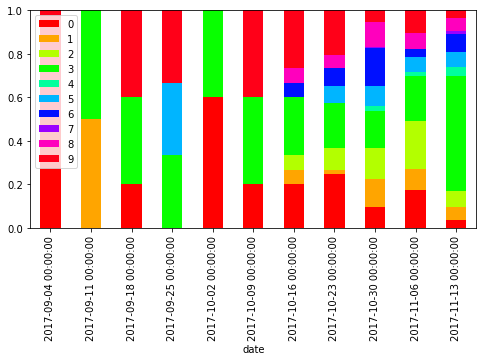

In [174]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 1, 10)
number = n_topics
cmap = plt.get_cmap('hsv')
colors = [cmap(i) for i in np.linspace(0, 1, number)]


topic_probas = pvtm.gmm.predict_proba(pvtm.doc_vectors)

df['day']= pd.to_datetime(df.date).dt.ceil('D')
df['day']= df.day.apply(lambda x: x-pd.DateOffset(weekday=0,weeks=1))
df['idx'] = df.index.values
topics_over_time = pd.DataFrame([topic_probas[row].mean(axis=0) for row in df.groupby('day').idx.apply(list).values])
topics_over_time['date'] = df.groupby('day').day.apply(list).index.values
topics_over_time['date'] = pd.to_datetime(topics_over_time['date'])
topics_over_time = topics_over_time.set_index('date')
topics_over_time.plot(kind='bar', stacked=True, figsize=(8,4), color=colors)

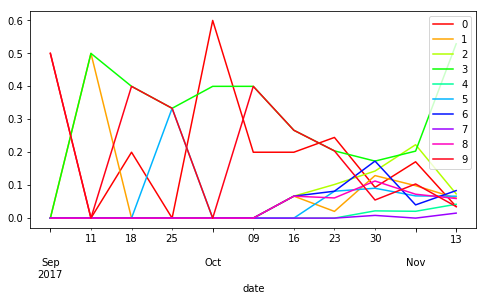

In [176]:
topics_over_time.plot(kind='line', stacked=False, figsize=(8,4), color=colors)

# LDA

In [20]:
df.shape

(21800, 9)

In [21]:
from cleantext import clean
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
    
def clean_text(text):
    return clean(text,
                fix_unicode=True,              # fix various unicode errors
                to_ascii=True,                 # transliterate to closest ASCII representation
                lower=False,                   # lowercase text
                no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
                no_urls=True,                  # replace all URLs with a special token
                no_emails=True,                # replace all email addresses with a special token
                no_phone_numbers=True,         # replace all phone numbers with a special token
                no_numbers=True,               # replace all numbers with a special token
                no_digits=True,                # replace all digits with a special token
                no_currency_symbols=True,      # replace all currency symbols with a special token
                no_punct=False,                 # fully remove punctuation
                replace_with_url="<URL>",
                replace_with_email="<EMAIL>",
                replace_with_phone_number="<PHONE>",
                replace_with_number="<NUMBER>",
                replace_with_digit="0",
                replace_with_currency_symbol="<CUR>",
                lang="en"                       # set to 'de' for German special handling
            )

   
# Load data and get tfidf vecs
x = df['body'].values#[:100]
%time x = [clean_text(xx) for xx in x]
tfidf = TfidfVectorizer(min_df = 0.005, max_df = 0.5)
%time xvecs = tfidf.fit_transform(x)
print(xvecs.shape)

Wall time: 14.2 s
Wall time: 1.88 s
(21800, 2110)


In [22]:
lda1 = LatentDirichletAllocation(n_components=10, max_iter=500)
%time lda1.fit(xvecs)
# get lda topic word distributions
topics1 = lda1.components_
# lda index to words
tf_feature_names = tfidf.get_feature_names()
print_top_words(lda1, tf_feature_names, 9)

Wall time: 24min 16s


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=500,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

Topic #0:
fur number man fahren zu mehr mit ein auto
Topic #1:
fur gut schutzt inwiefern man besser sind auch zerstort
Topic #2:
fur wir ja es zu klima auch um geht
Topic #3:
ich du es zu auch man aber fur wenn
Topic #4:
fur bio url es auch als naturschutz bau zu
Topic #5:
zuliebe an fur sich du sie bitte ich zu
Topic #6:
number url flair de nachrichten top pos reddit humor
Topic #7:
zu es von den auch ich dass number fur
Topic #8:
the to of and is it url that you
Topic #9:
grunen partei cdu spd fdp afd wahlen parteien grune



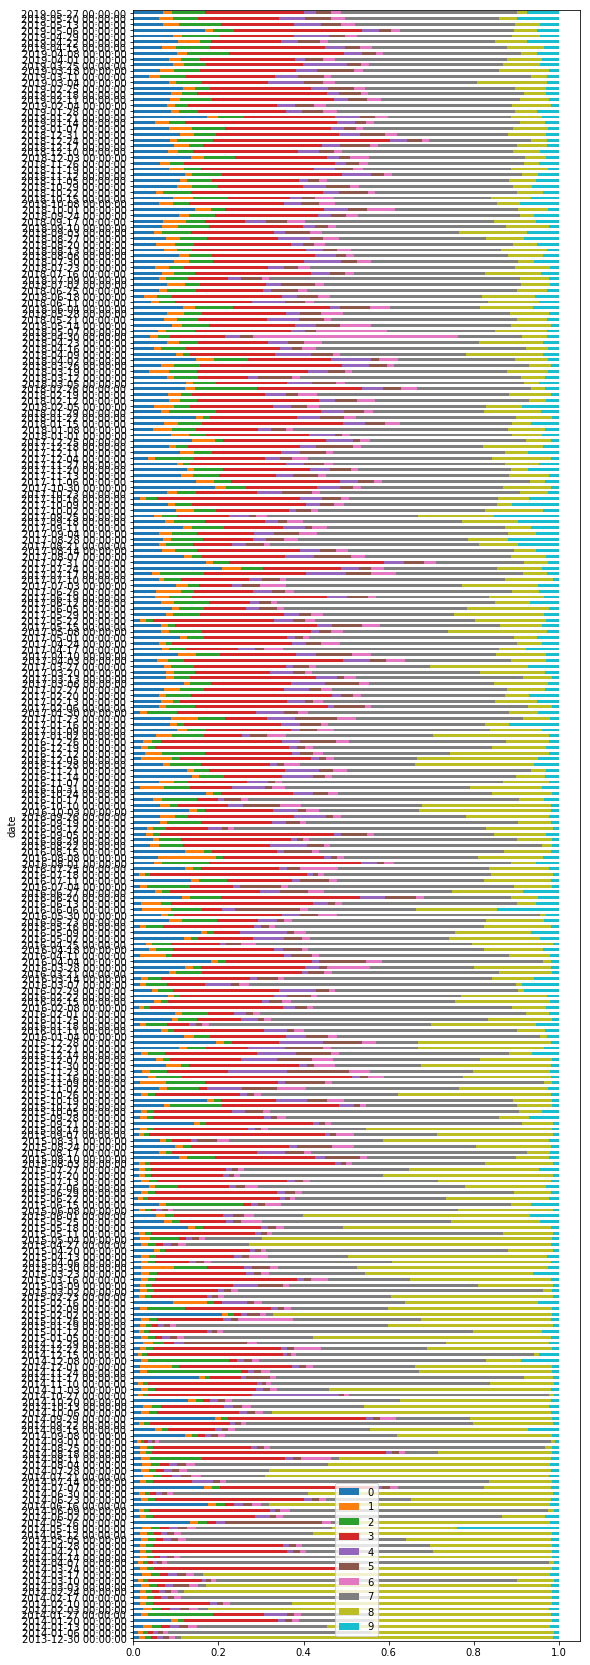

In [24]:
topic_probas = lda1.transform(xvecs)

# df = df.iloc[:100]

df['day']= pd.to_datetime(df.date).dt.ceil('D')
df['day']= df.day.apply(lambda x: x-pd.DateOffset(weekday=0,weeks=1))
df['idx'] = df.index.values
topics_over_time = pd.DataFrame([topic_probas[row].mean(axis=0) for row in df.groupby('day').idx.apply(list).values])
topics_over_time['date'] = df.groupby('day').day.apply(list).index.values
topics_over_time['date'] = pd.to_datetime(topics_over_time['date'])
topics_over_time = topics_over_time.set_index('date')
topics_over_time.plot(kind='barh', stacked=True, figsize=(8,30))